In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import torch

torch.manual_seed(42)
np.random.seed(42)

class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, noise_dim, label_dim):
        super().__init__()
        self.input = nn.Linear(noise_dim + label_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, input_dim)

    def forward(self, noise, label):
        out = self.input(torch.cat((noise, label), -1))
        out = F.relu(out)
        out = self.hidden(out)
        out = F.relu(out)
        out = self.output(out)

        return out


class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim):
        super().__init__()
        self.input = nn.Linear(input_dim + label_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, 1)
    
    def forward(self, x, label):
        out = self.input(torch.cat((x, label), -1))
        out = F.relu(out)
        out = self.hidden(out)
        out = F.relu(out)
        out = self.output(out)
        
        return out

In [2]:
# Load dataset 
bos = load_boston()
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df["Price"] = bos.target

# Standardize
data = df[df.columns[:-1]]
data = data.apply(
    lambda x: (x - x.mean()) / x.std()
)

data['Price'] = df.Price

print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  Price  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2  


In [3]:
# # Dataset to tensor 
# X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
# Y = torch.tensor(data["Price"].values).type(torch.float64)

# # Split dataset for test and train
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
# Y_train = Y_train.view(-1, 1)
# Y_test = Y_test.view(-1, 1)

In [4]:
# # Define hyperparameters 
# N_EPOCHS = 50
# BATCH_SIZE = 128
# lr = 0.0001
# INPUT_DIM = X_train.shape[1]
# LABEL_DIM = Y_train.shape[1]
# NOISE_DIM = 5
# HIDDEN_DIM = 20 

In [5]:
# # Iterable train data 
# train_data = torch.utils.data.TensorDataset(X_train, Y_train)
# train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# # Define the models
# gen = Generator(INPUT_DIM, HIDDEN_DIM, NOISE_DIM, LABEL_DIM).type(torch.float64)
# dis = Discriminator(INPUT_DIM, LABEL_DIM, HIDDEN_DIM).type(torch.float64)

# prior = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

In [7]:
# # Define optimizers 
# optG = torch.optim.Adam(gen.parameters(), lr=lr)
# optD = torch.optim.Adam(dis.parameters(), lr=lr)

# logsigmoid = torch.nn.LogSigmoid()

In [8]:
# for ep in range(N_EPOCHS):
#     for x, y in train_iter:
#         N = len(x)
        
#         """ Train discriminator """
#         ## 1. Real data ##
#         # Zero grad 
#         optD.zero_grad()
        
#         # Forward pass on discriminator 
#         outD = dis(x, y)
        
#         ## 2. Generated data ##
#         # Forward pass on generator 
#         noise = prior.sample((N, NOISE_DIM)).type(torch.float64)
#         outG_dis = gen(noise, y)
        
#         # Forward pass on discriminator 
#         outDG_dis = dis(outG_dis, y)
        
#         ## 3. Loss ##
#         lossD = -torch.mean(logsigmoid(outD) + logsigmoid(1 - outDG_dis))
        
#         # Backward 
#         lossD.backward()
        
#         # Update parameters
#         optD.step()
        
        
#         """ Train Generator """
#         # Zero grad 
#         optG.zero_grad()
        
#         # Forward pass on generator 
#         # TODO: find out if I should use the same noise as above or sample
#         #  new noise
#         noise = prior.sample((N, NOISE_DIM)).type(torch.float64)
#         outG_gen = gen(noise, y)
        
#         # Forward pass on discriminator 
#         outDG_gen = dis(outG_gen, y)
        
#         # Loss 
#         lossG = -torch.mean(logsigmoid(outDG_gen))
        
#         # Backward 
#         lossG.backward()
        
#         # Update parameters 
#         optG.step()
        
    
#     print("Train Epoch: {} LossD: {} LossG: {}".format(ep + 1, lossD, lossG))


## Test

In [9]:
# # Iterable test data 
# test_data = torch.utils.data.TensorDataset(X_test, Y_test)
# test_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# for ep, (x, y) in enumerate(test_iter):
#     N = len(x)
    
#     """ Testing discriminator """
#     ## 1. Real data ## 
#     outD = dis(x, y)
    
#     ## 2. Generated data ##
#     noise_dis = prior.sample((N, NOISE_DIM)).type(torch.float64)
#     outG_dis = gen(noise_dis, y)
#     outDG_dis = dis(outG_dis, y)
    
#     ## 3. Loss ##
#     lossD = -torch.mean(logsigmoid(outD) + logsigmoid(1 - outDG_dis))
    
#     """ Testing generator """
#     noise_gen = prior.sample((N, NOISE_DIM)).type(torch.float64)
#     outG_gen = gen(noise_gen, y)
#     outDG_gen = dis(outG_gen, y)
    
#     # Loss 
#     lossG = -torch.mean(logsigmoid(outDG_gen))
    
#     print("Train Epoch: {} LossD: {} LossG: {}".format(ep + 1, lossD, lossG))

## 1-NN

In [11]:
from sklearn.model_selection import LeaveOneOut
# Define the models
# Dataset to tensor 
# 
X = torch.tensor(data.drop("Price", axis=1).values).type(torch.float64)
Y = torch.tensor(data["Price"].values).type(torch.float64).view(-1, 1)

X_TRAIN, X_test, Y_TRAIN, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
Y_TRAIN = Y_TRAIN.view(-1, 1)
Y_test = Y_test.view(-1, 1)

# Define hyperparameters 
N_EPOCHS = 50
BATCH_SIZE = 128
lr = 0.001
INPUT_DIM = X.shape[1]
LABEL_DIM = Y.shape[1]
NOISE_DIM = 5
HIDDEN_DIM = 20 

In [12]:
# Define the models
gen = Generator(INPUT_DIM, HIDDEN_DIM, NOISE_DIM, LABEL_DIM).type(torch.float64)
dis = Discriminator(INPUT_DIM, LABEL_DIM, HIDDEN_DIM).type(torch.float64)

prior = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

In [13]:
# Define optimizers 
optG = torch.optim.Adam(gen.parameters(), lr=lr)
optD = torch.optim.Adam(dis.parameters(), lr=lr)

logsigmoid = torch.nn.LogSigmoid()

In [14]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
print(loo.get_n_splits(X_TRAIN))
print(len(X_TRAIN))

354
354


In [15]:
train_accs = torch.tensor([])
test_accs = torch.tensor([])


for ep in range(N_EPOCHS):
    train_accuracy = 0
    num_samples = 0 
    for train_index, test_train_index in loo.split(X_TRAIN):
        X_train, X_test_train = X[train_index], X[test_train_index]
        Y_train, Y_test_train = Y[train_index], Y[test_train_index]
        
        N = len(X_train)
        
        """ Train Discriminator """
        # zero grad 
        optD.zero_grad()
        
        # Forward pass 
        # 1. Discriminator 
        outD = dis(X_train, Y_train)
        
        # 2. Generator-Discriminator
        noise_dis = prior.sample((N, NOISE_DIM)).type(torch.float64)
        outG_dis = gen(noise_dis, Y_train)
        outDG_dis = dis(outG_dis, Y_train)
        
        # Loss
        lossD = -torch.mean(logsigmoid(outD) + logsigmoid(1 - outDG_dis))
        
        # Backward
        lossD.backward()
        
        # Update parameters 
        optD.step()
                
        """ Train Generator """
        # zero grad 
        optG.zero_grad()
        
        # Forward pass 
        noise_gen = prior.sample((N, NOISE_DIM)).type(torch.float64)
        outG_gen = gen(noise_gen, Y_train)
        outDG_gen = dis(outG_gen, Y_train)
        
        # Loss 
        lossG = -torch.mean(logsigmoid(outDG_gen))
        
        # Backward 
        lossG.backward()
        
        # Update parameters 
        optG.step()
        
#         """ Train Accuracy """
#         outD_acc = dis(X_train, Y_train)
        
#         noise_acc = prior.sample((N, NOISE_DIM)).type(torch.float64)
#         outG_acc = gen(noise_acc, Y_train)
#         outDG_acc = dis(outG_acc, Y_train)
        
#         train_accuracy += torch.sum((outD_acc > 0.5) == 1).item()
#         train_accuracy += torch.sum((outDG_acc > 0.5) == 0).item()
# #         accuracy = torch.sum((outD > 0.5) == 1) + torch.sum((outDG_gen > 0.5) == 0)
        
        """ Train Accuracy (Leave one out) """
        # Forward pass
        # 1. Discriminator
        outD = dis(X_test_train, Y_test_train)
        outD = torch.nn.Sigmoid()(outD[0,0])
        outD_acc = int((outD > 0.5) == 1)
        
        train_accuracy += outD_acc 
        num_samples += 1
        

        # 2. Generator-Discriminator
        noise = prior.sample((1, NOISE_DIM)).type(torch.float64)
        outG = gen(noise, Y_test_train)
        outDG = dis(outG, Y_test_train)
        outDG = torch.nn.Sigmoid()(outDG[0,0])
        outDG_accuracy = int((outDG > 0.5) == 0)
        
        train_accuracy += outDG_accuracy
        num_samples += 1     
    
    train_accuracy = train_accuracy / num_samples
    print("Epochs: ", ep + 1, "Train accuracy: ", train_accuracy)
    
    train_accs = torch.cat((train_accs, torch.tensor([train_accuracy])))

    # https://arxiv.org/pdf/1802.03446.pdf
    # https://arxiv.org/pdf/1610.06545.pdf

Epochs:  1 Train accuracy:  0.5225988700564972
Epochs:  2 Train accuracy:  0.5847457627118644
Epochs:  3 Train accuracy:  0.501412429378531
Epochs:  4 Train accuracy:  0.5240112994350282
Epochs:  5 Train accuracy:  0.5338983050847458
Epochs:  6 Train accuracy:  0.5169491525423728
Epochs:  7 Train accuracy:  0.4858757062146893
Epochs:  8 Train accuracy:  0.481638418079096
Epochs:  9 Train accuracy:  0.5070621468926554
Epochs:  10 Train accuracy:  0.5296610169491526
Epochs:  11 Train accuracy:  0.7401129943502824
Epochs:  12 Train accuracy:  0.5466101694915254
Epochs:  13 Train accuracy:  0.4971751412429379
Epochs:  14 Train accuracy:  0.5720338983050848
Epochs:  15 Train accuracy:  0.53954802259887
Epochs:  16 Train accuracy:  0.5268361581920904
Epochs:  17 Train accuracy:  0.5494350282485876
Epochs:  18 Train accuracy:  0.501412429378531
Epochs:  19 Train accuracy:  0.5127118644067796
Epochs:  20 Train accuracy:  0.5211864406779662
Epochs:  21 Train accuracy:  0.5819209039548022
Epochs

tensor([0.5226, 0.5847, 0.5014, 0.5240, 0.5339, 0.5169, 0.4859, 0.4816, 0.5071,
        0.5297, 0.7401, 0.5466, 0.4972, 0.5720, 0.5395, 0.5268, 0.5494, 0.5014,
        0.5127, 0.5212, 0.5819, 0.5297, 0.5155, 0.5099, 0.5042, 0.5367, 0.5579,
        0.4576, 0.5099, 0.4534, 0.5720, 0.4845, 0.4859, 0.4972, 0.5395, 0.5395,
        0.5551, 0.5000, 0.4944, 0.4746, 0.5014, 0.4859, 0.5395, 0.5184, 0.5452,
        0.5395, 0.4802, 0.5480, 0.6172, 0.6059])


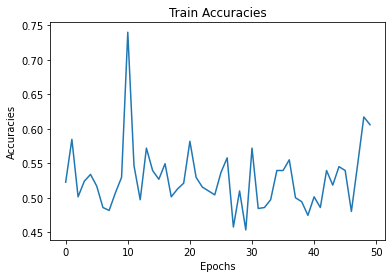

In [16]:
""" Plot losses """
import matplotlib.pyplot as plt 

# fig, axs = plt.subplots(1, 2, figsize=(20, 5))
print(train_accs)
plt.plot(train_accs)
plt.title("Train Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.show()

In [17]:
# Test Test 
outD = dis(X_test, Y_test)

noise = prior.sample((len(X_test), NOISE_DIM)).type(torch.float64)
outG = gen(noise, Y_test)
outDG = dis(outG, Y_test)

output = torch.cat((outD, outDG))
label_real = torch.ones(outD.shape)
label_fake = torch.zeros(outDG.shape)
labels = torch.cat((label_real, label_fake))

accuracy = torch.mean(((output > 0.5) == labels).type(torch.float64)).item()

print("Final test accuracy on held out data: ", accuracy)

Final test accuracy on held out data:  0.7138157894736842
